# Fashion Detection: Image Classification with CNN

#### authors: [@MelissaPerez09](https://github.com/MelissaPerez09), [@bl33h](https://github.com/bl33h), [@Mendezg1](https://github.com/Mendezg1)

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import numpy as np

In [2]:
images_dir = "./data/JPEGImages/"
annotations_dir = "./data/Annotations/"
labels = "./data/labels.txt"

In [3]:
image_files = os.listdir(images_dir)
image_ids = [os.path.splitext(file)[0] for file in image_files if file.lower().endswith(('.jpg', '.jpeg', '.png'))]

In [4]:
# read labels
with open(labels, 'r') as f:
    labels = [label.strip().replace(',', '') for label in f.read().splitlines()]

# map labels to integers
label_map = {label: idx for idx, label in enumerate(labels)}

print(label_map)

{'sunglass': 0, 'hat': 1, 'jacket': 2, 'shirt': 3, 'pants': 4, 'shorts': 5, 'skirt': 6, 'dress': 7, 'bag': 8, 'shoe': 9}


In [5]:
# load image and bounding boxes
def load_image_and_boxes(image_id):
    # load image
    image_path = os.path.join(images_dir, f"{image_id}.jpg")
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # load bounding boxes (annotations xml)
    annotation_path = os.path.join(annotations_dir, f"{image_id}.xml")
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    
    boxes = []
    labels = []
    
    for obj in root.findall('object'):
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        
        # bounding box coordinates
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        
        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(label_map[label])
    
    return image, boxes, labels

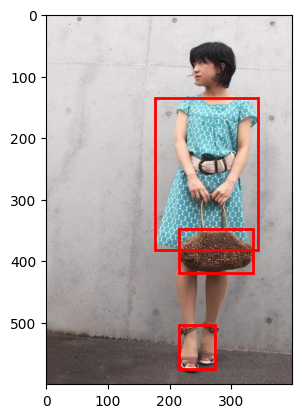

In [6]:
# visualize image and bounding boxes

image, boxes, labels = load_image_and_boxes(image_ids[0])

plt.imshow(image)
for box in boxes:
    xmin, ymin, xmax, ymax = box
    plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='red', linewidth=2))
plt.show()

In [7]:
def apply_clahe_rgb(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

In [8]:
cropped_images_array = []

def normalize_image(image):
    return image / 255.0

# Function to crop and normalize images, and save them in an array
def crop_normalize_and_save_images_to_array(image_id, cropped_images_array, target_size=(128, 128)):
    image, boxes, labels = load_image_and_boxes(image_id)
    
    for idx, box in enumerate(boxes):
        xmin, ymin, xmax, ymax = box
        cropped_image = image[ymin:ymax, xmin:xmax]
        resized_image = cv2.resize(cropped_image, target_size, interpolation=cv2.INTER_CUBIC)
        cropped_images_array.append((resized_image, labels[idx], image_id))

for image_id in image_ids[:2144]:
    crop_normalize_and_save_images_to_array(image_id, cropped_images_array)

In [9]:
def quality_improvement(image):
    clahe_image = apply_clahe_rgb(image)
    bilateral_filtered = cv2.bilateralFilter(clahe_image, d=9, sigmaColor=75, sigmaSpace=75)

    kernel = np.array([[0, -0.5, 0],
                   [-0.5, 3, -0.5],
                   [0, -0.5, 0]])
    sharpened = cv2.filter2D(bilateral_filtered, -1, kernel)
    

    return normalize_image(sharpened)

improved_images_array = []
# Apply quality improvement to cropped images
for idx, (image, label, id) in enumerate(cropped_images_array):
    improved_image = quality_improvement(image)
    improved_images_array.append((improved_image, label, id))

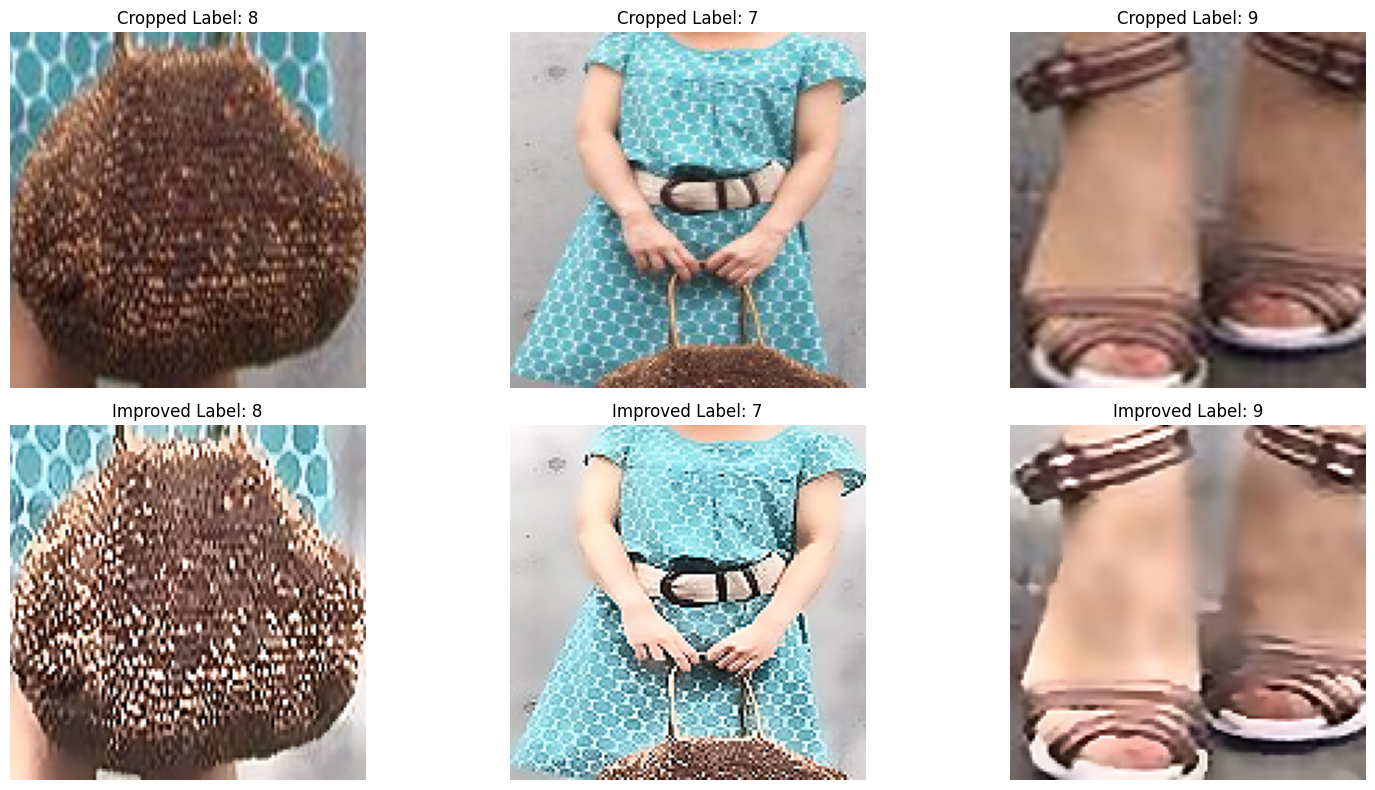

In [10]:
fig, axs = plt.subplots(2, 3, figsize=(16, 8))

for i in range(3):
    img, label, _ = cropped_images_array[i]
    axs[0, i].imshow(img)
    axs[0, i].set_title(f"Cropped Label: {label}")
    axs[0, i].axis('off')

for i in range(3):
    img, label, _ = improved_images_array[i]
    axs[1, i].imshow(img)
    axs[1, i].set_title(f"Improved Label: {label}")
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()

In [11]:
from collections import defaultdict

new_images_array = []

improved_by_image = defaultdict(list)
for improved_image, label, image_id in improved_images_array:
    improved_by_image[image_id].append((improved_image, label))


for idx, (image_id, improved_list) in enumerate(improved_by_image.items()):
    image, boxes, labels_in_image = load_image_and_boxes(image_id)
    image_overlay = image.copy()
    # For each improved image, find its bounding box and overlay
    for (improved_image, label) in improved_list:
        # Find the index of the bounding box for this label
        try:
            box_idx = labels_in_image.index(label)
        except ValueError:
            continue  # skip if label not found
        xmin, ymin, xmax, ymax = boxes[box_idx]
        improved_img_uint8 = (improved_image * 255).astype(np.uint8)
        improved_resized = cv2.resize(improved_img_uint8, (xmax - xmin, ymax - ymin), interpolation=cv2.INTER_CUBIC)
        image_overlay[ymin:ymax, xmin:xmax] = improved_resized
    new_images_array.append((image_overlay, labels_in_image))
        

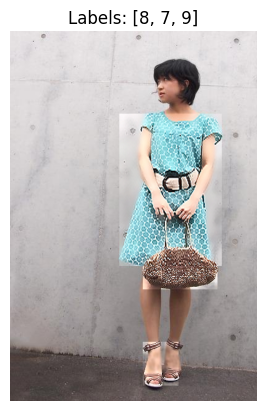

In [12]:
img, labels = new_images_array[0]
plt.imshow(img)
plt.title(f"Labels: {labels}")
plt.axis('off')
plt.show()

In [13]:
import os
import cv2

output_dir = "./data/Images"
os.makedirs(output_dir, exist_ok=True)

# It only needs to save the images once
if len(os.listdir(output_dir)) == 0:
    for idx, (img, labels) in enumerate(new_images_array):
        filename = os.path.join(output_dir, f"image_{idx}.png")
        cv2.imwrite(filename, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    print("Images saved.")
else:
    print("Images already exist. Skipping save.")


Images already exist. Skipping save.


In [14]:
from ultralytics import YOLO
import yaml
import os
from sklearn.model_selection import train_test_split

# Prepare YOLO dataset directory structure
if not os.path.exists('./data/yolo_dataset'):
    yolo_dataset_dir = './data/yolo_dataset'
    images_output_dir = os.path.join(yolo_dataset_dir, 'images')
    labels_output_dir = os.path.join(yolo_dataset_dir, 'labels')
    os.makedirs(images_output_dir, exist_ok=True)
    os.makedirs(labels_output_dir, exist_ok=True)

    # Save images and labels in YOLO format
    indices = np.arange(len(new_images_array))
    train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42, shuffle=True)

    for split, split_indices in zip(['train', 'val'], [train_indices, val_indices]):
        split_images_dir = os.path.join(images_output_dir, split)
        split_labels_dir = os.path.join(labels_output_dir, split)
        os.makedirs(split_images_dir, exist_ok=True)
        os.makedirs(split_labels_dir, exist_ok=True)
        for idx in split_indices:
            img, labels_in_image = new_images_array[idx]
            img_filename = f'image_{idx}.jpg'
            img_path = os.path.join(split_images_dir, img_filename)
            cv2.imwrite(img_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

            image_id = image_ids[idx]
            _, boxes, labels = load_image_and_boxes(image_id)

            label_path = os.path.join(split_labels_dir, f'image_{idx}.txt')
            h, w = img.shape[:2]
            with open(label_path, 'w') as f:
                for box, label in zip(boxes, labels):
                    xmin, ymin, xmax, ymax = box
                    x_center = ((xmin + xmax) / 2) / w
                    y_center = ((ymin + ymax) / 2) / h
                    width = (xmax - xmin) / w
                    height = (ymax - ymin) / h
                    f.write(f"{label} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

        image_id = image_ids[idx]
        _, boxes, labels = load_image_and_boxes(image_id)

        label_path = os.path.join(labels_output_dir, f'image_{idx}.txt')
        h, w = img.shape[:2]
        with open(label_path, 'w') as f:
            for box, label in zip(boxes, labels):
                xmin, ymin, xmax, ymax = box
                x_center = ((xmin + xmax) / 2) / w
                y_center = ((ymin + ymax) / 2) / h
                width = (xmax - xmin) / w
                height = (ymax - ymin) / h
                f.write(f"{label} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

# Create dataset YAML file
data_yaml = {
    'train': os.path.join(images_output_dir, 'train'),
    'val': os.path.join(images_output_dir, 'val'),
    'nc': len(label_map),
    'names': list(label_map.keys())
}

with open(os.path.join(yolo_dataset_dir, 'data.yaml'), 'w') as f:
    yaml.dump(data_yaml, f)


In [16]:
from ultralytics import YOLO
import os

model = YOLO('yolov8n.pt')

current_dir = os.getcwd()
yolo_dataset_dir = os.path.join(current_dir, 'data', 'yolo_dataset')

model.train(
    data=os.path.join(yolo_dataset_dir, 'data.yaml'),
    epochs=15,
    imgsz=512,
    batch=8,
    workers=4,
    optimizer="SGD",
    lr0=0.001,
    project=yolo_dataset_dir,
    name="fashion_detection"
)

Ultralytics 8.3.150  Python-3.9.13 torch-2.3.1+cpu CPU (11th Gen Intel Core(TM) i7-1165G7 2.80GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=c:\Users\sarap\Documents\fashion-detection-v2\src\data\yolo_dataset\data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=fashion_detection2, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap

100%|██████████| 755k/755k [00:00<00:00, 3.87MB/s]


Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

train: Scanning C:\Users\sarap\Documents\fashion-detection-v2\src\data\yolo_dataset\labels\train... 1715 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1715/1715 [00:05<00:00, 294.98it/s]


train: New cache created: C:\Users\sarap\Documents\fashion-detection-v2\src\data\yolo_dataset\labels\train.cache
val: Fast image access  (ping: 0.20.1 ms, read: 6.31.9 MB/s, size: 81.5 KB)


val: Scanning C:\Users\sarap\Documents\fashion-detection-v2\src\data\yolo_dataset\labels\val... 429 images, 0 backgrounds, 0 corrupt: 100%|██████████| 429/429 [00:01<00:00, 265.20it/s]

val: New cache created: C:\Users\sarap\Documents\fashion-detection-v2\src\data\yolo_dataset\labels\val.cache


Plotting labels to c:\Users\sarap\Documents\fashion-detection-v2\src\data\yolo_dataset\fashion_detection2\labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to c:\Users\sarap\Documents\fashion-detection-v2\src\data\yolo_dataset\fashion_detection2
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15         0G      1.383      4.016      1.421         18        512: 100%|██████████| 215/215 [09:29<00:00,  2.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:54<00:00,  2.01s/it]

                   all        429       1663    0.00955      0.646     0.0909     0.0485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15         0G      1.233      3.222       1.26         11        512: 100%|██████████| 215/215 [09:42<00:00,  2.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [01:10<00:00,  2.61s/it]


                   all        429       1663      0.531      0.245      0.224      0.135

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15         0G      1.187      2.453      1.243         23        512: 100%|██████████| 215/215 [10:29<00:00,  2.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [01:00<00:00,  2.24s/it]

                   all        429       1663      0.559      0.471      0.393      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15         0G      1.107      2.028      1.199         18        512: 100%|██████████| 215/215 [08:42<00:00,  2.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:58<00:00,  2.16s/it]

                   all        429       1663      0.703      0.521      0.537      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15         0G      1.033      1.784      1.157         24        512: 100%|██████████| 215/215 [08:34<00:00,  2.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [01:01<00:00,  2.27s/it]

                   all        429       1663      0.744      0.581      0.647      0.478


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15         0G     0.9561      1.858      1.149         12        512: 100%|██████████| 215/215 [12:31<00:00,  3.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [01:14<00:00,  2.77s/it]


                   all        429       1663      0.659      0.672      0.706      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15         0G     0.9073      1.678      1.117         10        512: 100%|██████████| 215/215 [10:40<00:00,  2.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [01:16<00:00,  2.85s/it]


                   all        429       1663      0.709      0.716      0.741      0.558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15         0G     0.8708      1.599      1.096         10        512: 100%|██████████| 215/215 [10:04<00:00,  2.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [01:19<00:00,  2.96s/it]


                   all        429       1663      0.736      0.699      0.754       0.57

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15         0G      0.855      1.547      1.094          9        512: 100%|██████████| 215/215 [10:37<00:00,  2.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:53<00:00,  1.99s/it]

                   all        429       1663      0.743      0.723      0.774      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15         0G     0.8419      1.499      1.076         13        512: 100%|██████████| 215/215 [09:11<00:00,  2.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [01:12<00:00,  2.67s/it]


                   all        429       1663      0.745      0.739       0.78      0.599

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15         0G     0.8202      1.453      1.075         11        512: 100%|██████████| 215/215 [11:49<00:00,  3.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [01:24<00:00,  3.14s/it]

                   all        429       1663       0.75      0.738      0.788      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15         0G     0.8117      1.437      1.061         10        512: 100%|██████████| 215/215 [10:44<00:00,  3.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [01:11<00:00,  2.65s/it]

                   all        429       1663      0.764      0.749      0.798      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15         0G     0.7944      1.406      1.059         11        512: 100%|██████████| 215/215 [11:09<00:00,  3.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [01:11<00:00,  2.65s/it]

                   all        429       1663      0.789      0.727      0.799      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15         0G     0.7958      1.381       1.05         14        512: 100%|██████████| 215/215 [11:11<00:00,  3.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [01:02<00:00,  2.32s/it]

                   all        429       1663      0.775      0.747      0.804      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15         0G     0.7863      1.375      1.043         12        512: 100%|██████████| 215/215 [10:09<00:00,  2.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [01:16<00:00,  2.85s/it]


                   all        429       1663       0.78      0.751      0.808      0.638

15 epochs completed in 2.874 hours.
Optimizer stripped from c:\Users\sarap\Documents\fashion-detection-v2\src\data\yolo_dataset\fashion_detection2\weights\last.pt, 6.2MB
Optimizer stripped from c:\Users\sarap\Documents\fashion-detection-v2\src\data\yolo_dataset\fashion_detection2\weights\best.pt, 6.2MB

Validating c:\Users\sarap\Documents\fashion-detection-v2\src\data\yolo_dataset\fashion_detection2\weights\best.pt...
Ultralytics 8.3.150  Python-3.9.13 torch-2.3.1+cpu CPU (11th Gen Intel Core(TM) i7-1165G7 2.80GHz)
Model summary (fused): 72 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [01:05<00:00,  2.41s/it]


                   all        429       1663       0.78      0.751      0.808      0.638
              sunglass         82         82       0.66      0.425       0.51      0.227
                   hat         53         53      0.717      0.868      0.832      0.626
                jacket        144        147      0.741      0.755      0.815      0.705
                 shirt        292        298      0.806      0.725      0.825      0.623
                 pants         93         93      0.895      0.914      0.937      0.808
                shorts         77         77      0.728      0.649      0.691      0.515
                 skirt        146        146      0.805      0.788      0.867      0.754
                 dress        111        111      0.751      0.847       0.89        0.8
                   bag        239        239      0.777      0.661      0.771      0.533
                  shoe        417        417      0.918      0.882      0.941      0.791
Speed: 1.1ms preproce

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000021D5173E550>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,   

In [17]:
metrics = model.val()
print("--- Metrics ---") 
print(metrics)

Ultralytics 8.3.150  Python-3.9.13 torch-2.3.1+cpu CPU (11th Gen Intel Core(TM) i7-1165G7 2.80GHz)
Model summary (fused): 72 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 465.0192.2 MB/s, size: 88.5 KB)


val: Scanning C:\Users\sarap\Documents\fashion-detection-v2\src\data\yolo_dataset\labels\val.cache... 429 images, 0 backgrounds, 0 corrupt: 100%|██████████| 429/429 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:53<00:00,  1.01it/s]


                   all        429       1663       0.78      0.751      0.808      0.638
              sunglass         82         82       0.66      0.425       0.51      0.227
                   hat         53         53      0.717      0.868      0.832      0.626
                jacket        144        147      0.741      0.755      0.815      0.705
                 shirt        292        298      0.806      0.725      0.825      0.623
                 pants         93         93      0.895      0.914      0.937      0.808
                shorts         77         77      0.728      0.649      0.691      0.515
                 skirt        146        146      0.805      0.788      0.867      0.754
                 dress        111        111      0.751      0.847       0.89        0.8
                   bag        239        239      0.777      0.661      0.771      0.533
                  shoe        417        417      0.918      0.882      0.941      0.791
Speed: 0.9ms preproce


image 1/1 c:\Users\sarap\Documents\fashion-detection-v2\src\data\yolo_dataset\images\val\image_100.jpg: 512x352 1 jacket, 1 shirt, 1 pants, 1 shoe, 77.1ms
Speed: 5.5ms preprocess, 77.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 352)


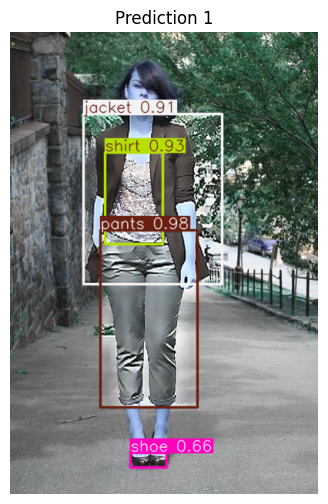


image 1/1 c:\Users\sarap\Documents\fashion-detection-v2\src\data\yolo_dataset\images\val\image_1000.jpg: 512x352 2 hats, 1 jacket, 1 shirt, 1 skirt, 1 bag, 1 shoe, 76.3ms
Speed: 1.6ms preprocess, 76.3ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 352)


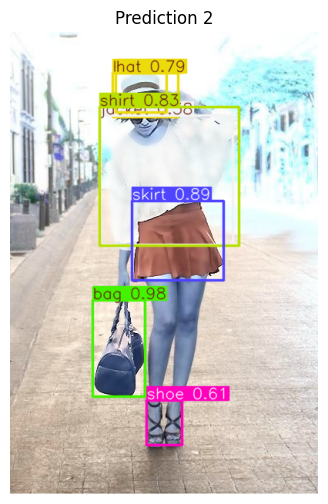


image 1/1 c:\Users\sarap\Documents\fashion-detection-v2\src\data\yolo_dataset\images\val\image_1001.jpg: 512x352 1 shirt, 1 pants, 1 shoe, 130.7ms
Speed: 1.3ms preprocess, 130.7ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 352)


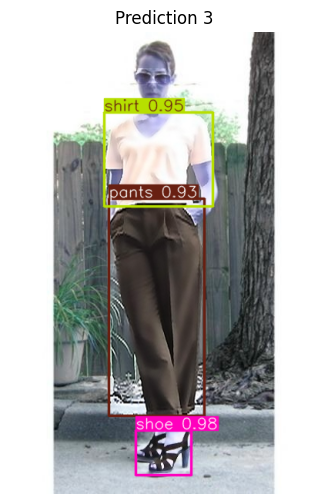


image 1/1 c:\Users\sarap\Documents\fashion-detection-v2\src\data\yolo_dataset\images\val\image_1004.jpg: 512x352 1 dress, 1 shoe, 85.1ms
Speed: 1.8ms preprocess, 85.1ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 352)


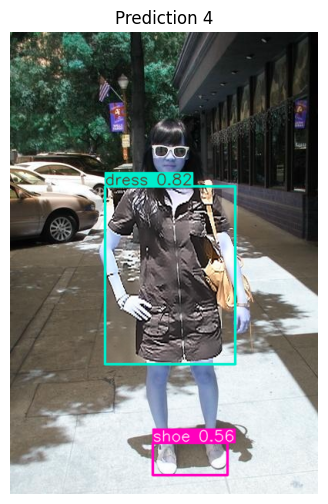


image 1/1 c:\Users\sarap\Documents\fashion-detection-v2\src\data\yolo_dataset\images\val\image_1022.jpg: 512x352 1 sunglass, 1 shirt, 1 skirt, 1 dress, 1 shoe, 70.1ms
Speed: 1.5ms preprocess, 70.1ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 352)


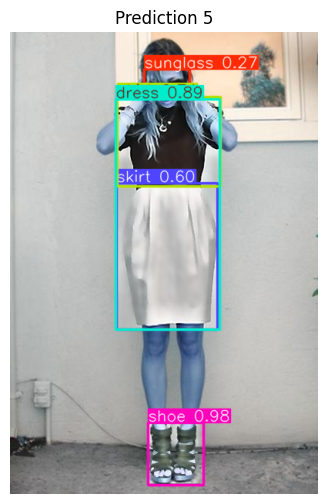

In [22]:
from pathlib import Path

val_image_path = Path("./data/yolo_dataset/images/val")

output_folder = "predictions_output"
os.makedirs(output_folder, exist_ok=True)

image_paths = list(val_image_path.glob("*.jpg"))[:5]

for i, image_path in enumerate(image_paths):
    result = model.predict(source=str(image_path), conf=0.25)
    annotated_img = result[0].plot()
    output_path = os.path.join(output_folder, f"pred_{i+1}.jpg")
    annotated_img_bgr = cv2.cvtColor(annotated_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_path, annotated_img_bgr)

    plt.figure(figsize=(4, 6))
    plt.imshow(annotated_img)
    plt.axis("off")
    plt.title(f"Prediction {i+1}")
    plt.show()


image 1/1 c:\Users\sarap\Documents\fashion-detection-v2\src\data\real\img.jpg: 384x512 1 shirt, 1 pants, 78.3ms
Speed: 2.9ms preprocess, 78.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 512)


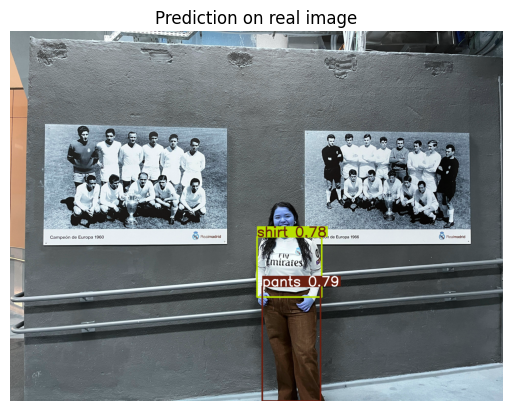

In [35]:
img_path = Path("data/real/img.jpg")
result = model.predict(source=str(img_path), conf=0.25)
plt.imshow(result[0].plot() ); plt.axis("off"); plt.title("Prediction on real image"); plt.show()